# Match predicter for national football

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#import
df = pd.read_csv('results.csv')
df
df.shape

(48366, 9)

In [2]:
#filtering
'''
uncomment if only important tournaments to use
rel_tournaments = [
    'FIFA World Cup',
    'UEFA Nations League',
    'UEFA Euro',
    'AFC Asian Cup',
    'African Cup of Nations',
    'Gold Cup',
    'Copa América',
    'Oceania Nations Cup'
]

df_filtered = df[df['tournament'].isin(rel_tournaments)].copy() #why copy?
'''
#check for null values and duplicates:
df.dropna(inplace=True)
df.drop_duplicates()
print(df.shape)

df_filtered = df[['date','home_team','away_team','home_score','away_score','tournament']].copy()

df_filtered.shape


(48366, 9)


(48366, 6)

In [3]:
#print first lines
print(df_filtered.head())

         date home_team away_team  home_score  away_score tournament
0  1872-11-30  Scotland   England           0           0   Friendly
1  1873-03-08   England  Scotland           4           2   Friendly
2  1874-03-07  Scotland   England           2           1   Friendly
3  1875-03-06   England  Scotland           2           2   Friendly
4  1876-03-04  Scotland   England           3           0   Friendly


## create pred. var


In [4]:
def determineResult(row):
    if row['home_score'] > row['away_score']:
        return 'H'  # Home won
    elif row['home_score'] < row['away_score']:
        return 'A'  # Away won
    else:
        return 'D'  # tie

df_filtered['result'] = df_filtered.apply(determineResult, axis=1)

## Prepare train test data

In [5]:
#simple feature engineering
le = LabelEncoder()
all_teams = pd.concat([df_filtered['home_team'], df_filtered['away_team']]).unique()
le.fit(all_teams)

df_filtered['home_id'] = le.transform(df_filtered['home_team'])
df_filtered['away_id'] = le.transform(df_filtered['away_team'])

#create ids
tournament_encoder = LabelEncoder()
df_filtered['tournament_id'] = tournament_encoder.fit_transform(df_filtered['tournament'])

features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

df_filtered

,date,home_team,away_team,home_score,away_score,tournament,result,home_id,away_id,tournament_id
0,1872-11-30,Scotland,England,0,0,Friendly,D,252,90,89
1,1873-03-08,England,Scotland,4,2,Friendly,H,90,252,89
2,1874-03-07,Scotland,England,2,1,Friendly,H,252,90,89
3,1875-03-06,England,Scotland,2,2,Friendly,D,90,252,89
4,1876-03-04,Scotland,England,3,0,Friendly,H,252,90,89
...,...,...,...,...,...,...,...,...,...,...
48361,2025-06-29,Canada,Guatemala,1,1,Gold Cup,D,48,120,91
48362,2025-06-29,United States,Costa Rica,2,2,Gold Cup,D,306,68,91
48363,2025-07-02,United States,Guatemala,2,1,Gold Cup,H,306,120,91
48364,2025-07-02,Mexico,Honduras,1,0,Gold Cup,H,183,129,91


## train model:

In [6]:
#split data
X = df_filtered[features]
y = df_filtered[target]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#actual model training
model_RF = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_split=2)

model_RF.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
#import joblib
#save model
#joblib.dump(model_RF, 'random_forest_model.pkl')


## Now logistic regression model for prediction

In [9]:
#prepare data again:
features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

X = df_filtered[features]
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#create model:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_log = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

model_log.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## evaluation of the models

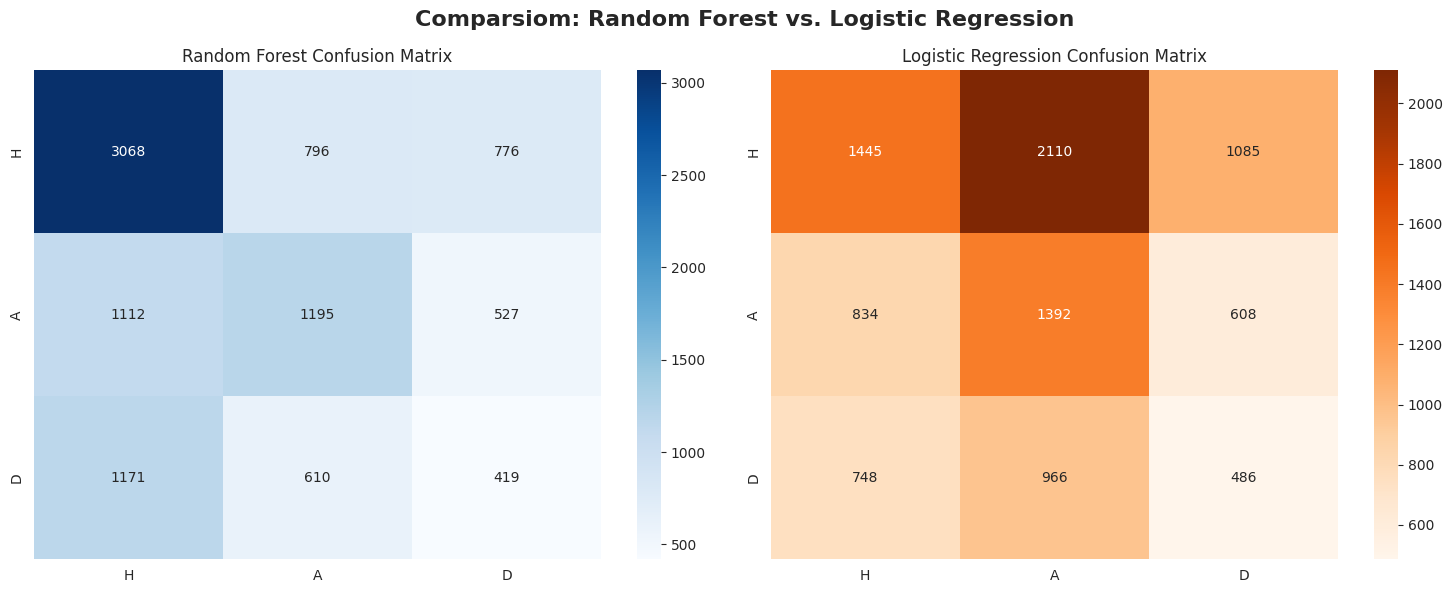

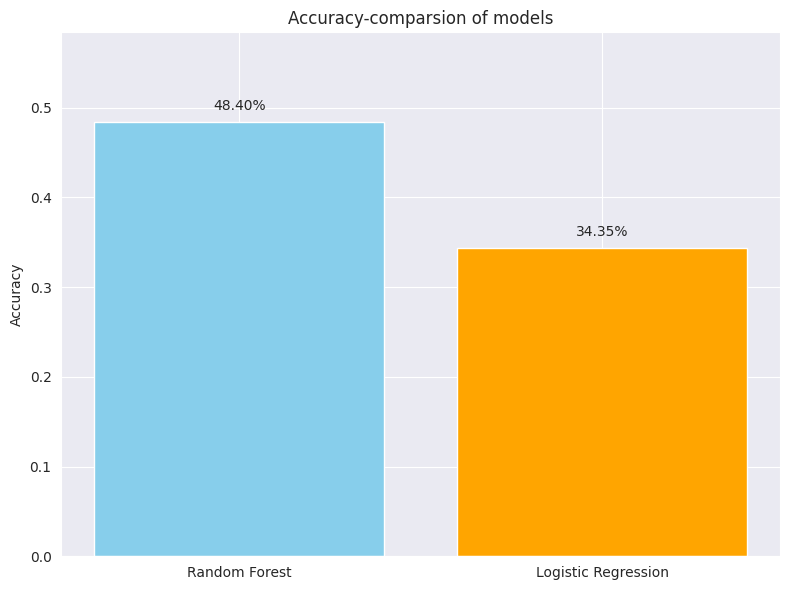

In [11]:
y_pred_rf = model_RF.predict(X_test)
y_pred_log = model_log.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
acc_log = accuracy_score(y_test, y_pred_log)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparsiom: Random Forest vs. Logistic Regression', fontsize=16, fontweight='bold')

#Confusion Matrix of Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['H', 'A', 'D'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[0].set_title('Random Forest Confusion Matrix')

#Confusion Matrix of Logistic regression
cm_log = confusion_matrix(y_test, y_pred_log, labels=['H', 'A', 'D'])
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[1].set_title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

#evaluate accuary
plt.figure(figsize=(8, 6))
models = ['Random Forest', 'Logistic Regression']
accuracies = [acc_rf, acc_log]

bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title('Accuracy-comparsion of models')
plt.ylabel('Accuracy')
plt.ylim(0, max(accuracies) + 0.1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [12]:
print('Classification Reports:')
print('Random forest:')
print(classification_report(y_test, y_pred_rf, zero_division=0))
print('logistic regression:')
print(classification_report(y_test, y_pred_log, zero_division=0))

Classification Reports:
Random forest:
              precision    recall  f1-score   support

           A       0.46      0.42      0.44      2834
           D       0.24      0.19      0.21      2200
           H       0.57      0.66      0.61      4640

    accuracy                           0.48      9674
   macro avg       0.43      0.42      0.42      9674
weighted avg       0.46      0.48      0.47      9674

logistic regression:
              precision    recall  f1-score   support

           A       0.31      0.49      0.38      2834
           D       0.22      0.22      0.22      2200
           H       0.48      0.31      0.38      4640

    accuracy                           0.34      9674
   macro avg       0.34      0.34      0.33      9674
weighted avg       0.37      0.34      0.34      9674

